# 1. 라이브러리 및 데이터

In [1]:
import numpy as np
import pandas as pd

# 데이터 시각화
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inLine

import missingno as msno

# 데이터 전처리
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# 모델링
import lightgbm as lgb

# 하이퍼파라미터 튜닝
from sklearn.model_selection import RandomizedSearchCV

# 성능 평가
from sklearn.metrics import accuracy_score

In [2]:
# 코랩 드라이브 마운트

from google.colab import drive
drive.mount('/content/drive')

# train, test, submission data 불러오기

org_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/인공지능/타이타닉_승객 이송/train.csv')
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/인공지능/타이타닉_승객 이송/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/인공지능/타이타닉_승객 이송/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/인공지능/타이타닉_승객 이송/submission.csv')

data.head()

Mounted at /content/drive


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
# 불필요한 변수 제거

data.drop(columns=['PassengerId','Name'], inplace=True)
test.drop(columns=['PassengerId','Name'], inplace=True)

In [4]:
# data 정보 요약 (변수명, 변수타입)
data.info()

# 전처리 필요

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Cabin         8494 non-null   object 
 3   Destination   8511 non-null   object 
 4   Age           8514 non-null   float64
 5   VIP           8490 non-null   object 
 6   RoomService   8512 non-null   float64
 7   FoodCourt     8510 non-null   float64
 8   ShoppingMall  8485 non-null   float64
 9   Spa           8510 non-null   float64
 10  VRDeck        8505 non-null   float64
 11  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(5)
memory usage: 755.7+ KB


# 2. 데이터 전처리

* 범주형 변수 인코딩

In [5]:
# 범주형 변수 인코딩 - HomePlanet

encoder = OrdinalEncoder()
data['HomePlanet'] = encoder.fit_transform(data['HomePlanet'].to_numpy().reshape(-1,1))
test['HomePlanet'] = encoder.transform(test['HomePlanet'].to_numpy().reshape(-1,1))
HomePlanet_cats = encoder.categories_

In [6]:
# 범주형 변수 인코딩 - CryoSleep

encoder = OrdinalEncoder()
data['CryoSleep'] = encoder.fit_transform(data['CryoSleep'].to_numpy().reshape(-1,1))
test['CryoSleep'] = encoder.transform(test['CryoSleep'].to_numpy().reshape(-1,1))
CryoSleep_cats = encoder.categories_

In [7]:
# Cabin 변수는 값이 너무 많음, 유용하지 않을 것으로 판단하여 삭제

data.drop(columns=['Cabin'], inplace=True)
test.drop(columns=['Cabin'], inplace=True)

In [8]:
# 범주형 변수 인코딩 - Destination

encoder = OrdinalEncoder()
data['Destination'] = encoder.fit_transform(data['Destination'].to_numpy().reshape(-1,1))
test['Destination'] = encoder.transform(test['Destination'].to_numpy().reshape(-1,1))
Destination_cats = encoder.categories_

In [9]:
# 범주형 변수 인코딩 - VIP

encoder = OrdinalEncoder()
data['VIP'] = encoder.fit_transform(data['VIP'].to_numpy().reshape(-1,1))
test['VIP'] = encoder.transform(test['VIP'].to_numpy().reshape(-1,1))
VIP_cats = encoder.categories_

In [10]:
# 범주형 변수 인코딩 - Transported

encoder = OrdinalEncoder()
data['Transported'] = encoder.fit_transform(data['Transported'].to_numpy().reshape(-1,1))
Transported_cats = encoder.categories_

* 결측치 처리

In [11]:
# 연속형 변수가 아닌 경우
# 가장 빈도가 많은 데이터로 결측치 처리

# HomePlanet
imputer = SimpleImputer(strategy='most_frequent')
data['HomePlanet'] = imputer.fit_transform(data['HomePlanet'].to_numpy().reshape(-1,1))
test['HomePlanet'] = imputer.transform(test['HomePlanet'].to_numpy().reshape(-1,1))

In [12]:
# CryoSleep

imputer = SimpleImputer(strategy='most_frequent')
data['CryoSleep'] = imputer.fit_transform(data['CryoSleep'].to_numpy().reshape(-1,1))
test['CryoSleep'] = imputer.transform(test['CryoSleep'].to_numpy().reshape(-1,1))

In [13]:
# VIP

imputer = SimpleImputer(strategy='most_frequent')
data['VIP'] = imputer.fit_transform(data['VIP'].to_numpy().reshape(-1,1))
test['VIP'] = imputer.transform(test['VIP'].to_numpy().reshape(-1,1))

In [14]:
# Destination

imputer = SimpleImputer(strategy='most_frequent')
data['Destination'] = imputer.fit_transform(data['Destination'].to_numpy().reshape(-1,1))
test['Destination'] = imputer.transform(test['Destination'].to_numpy().reshape(-1,1))

In [15]:
# 연속형 변수의 경우 평균값으로 결측치 채우기
# Age

imputer = SimpleImputer(strategy='mean')
data['Age'] = imputer.fit_transform(data['Age'].to_numpy().reshape(-1,1))
test['Age'] = imputer.transform(test['Age'].to_numpy().reshape(-1,1))

In [16]:
# RoomService

imputer = SimpleImputer(strategy='mean')
data['RoomService'] = imputer.fit_transform(data['RoomService'].to_numpy().reshape(-1,1))
test['RoomService'] = imputer.transform(test['RoomService'].to_numpy().reshape(-1,1))

In [17]:
# FoodCourt

imputer = SimpleImputer(strategy='mean')
data['FoodCourt'] = imputer.fit_transform(data['FoodCourt'].to_numpy().reshape(-1,1))
test['FoodCourt'] = imputer.transform(test['FoodCourt'].to_numpy().reshape(-1,1))

In [18]:
# ShoppingMall

imputer = SimpleImputer(strategy='mean')
data['ShoppingMall'] = imputer.fit_transform(data['ShoppingMall'].to_numpy().reshape(-1,1))
test['ShoppingMall'] = imputer.transform(test['ShoppingMall'].to_numpy().reshape(-1,1))

In [19]:
# Spa

imputer = SimpleImputer(strategy='mean')
data['Spa'] = imputer.fit_transform(data['Spa'].to_numpy().reshape(-1,1))
test['Spa'] = imputer.transform(test['Spa'].to_numpy().reshape(-1,1))

In [20]:
# VRDeck

imputer = SimpleImputer(strategy='mean')
data['VRDeck'] = imputer.fit_transform(data['VRDeck'].to_numpy().reshape(-1,1))
test['VRDeck'] = imputer.transform(test['VRDeck'].to_numpy().reshape(-1,1))

In [21]:
# 결측치 처리 확인

data.isnull().sum()

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
dtype: int64

# 3. EDA

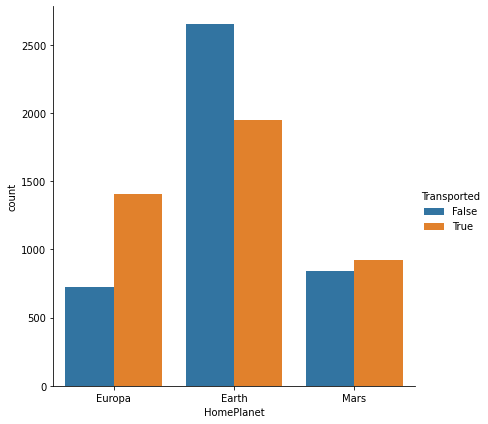

In [22]:
# 개별 항목의 분포 확인
# HomePlanet

sns.catplot(
    data=org_data,
    x='HomePlanet',
    kind='count',
    hue="Transported",
    aspect=1,
    height=6
)
plt.show()

# 대부분의 승객이 Earth에서 왔다
# Europa, Mars는 이송된 사람이 더 많지만 Earth는 이송되지 않은 사람이 더 많다

In [23]:
# Cryo Sleep 

fig = px.pie(
    names=org_data.CryoSleep.unique()[:-1],
    values=org_data.CryoSleep.value_counts(),
    width=500,
    hole=0.4,
)
fig.update_layout({'title':{'text':'Cryo Sleep','x':0.5}})
fig.show()

# 대다수의 사람들은 Cryo Sleep에 들지 않았다
# Cryo Sleep에 들지 않은 사람이 이송되었을 확률이 더 높을 것으로 예상할 수 있다

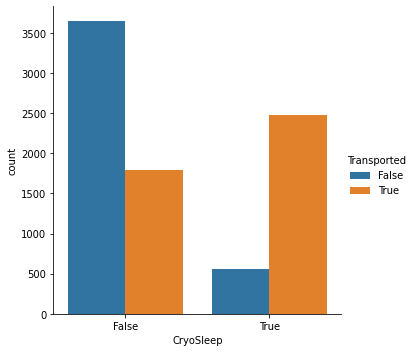

In [24]:
# Cryo Sleep (2)

sns.catplot(
    data=org_data,
    x='CryoSleep',
    kind='count',
    aspect=1,
    height=5,
    hue="Transported"
)
plt.show()

# CryoSleep과 Transported를 연관지어 봤을 때, CryoSleep에 든 사람이 그렇지 않은 사람보다 더 많이 이송되었다

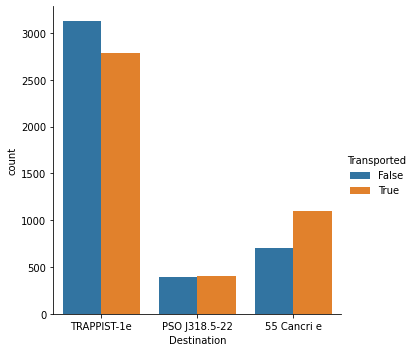

In [25]:
# Destination

fig = px.pie(
    names=org_data.Destination.unique()[:-1],
    values=data.Destination.value_counts(),
    width=500,
    hole=0.4,
)
fig.update_layout({'title':{'text':'Destination','x':0.45}})
fig.show()

sns.catplot(
    data=org_data,
    x='Destination',
    kind='count',
    aspect=1,
    height=5,
    hue="Transported"
)
plt.show()

# 목적지가 'TRAPPIST-1e'인 것이 이송자 수, 이송되지 않은 사람 수 모두 가장 많은데 이송자 수가 이송되지 않은 사람 수보다 적다 
# 나머지 두 곳은 이송자 수가 더 많다

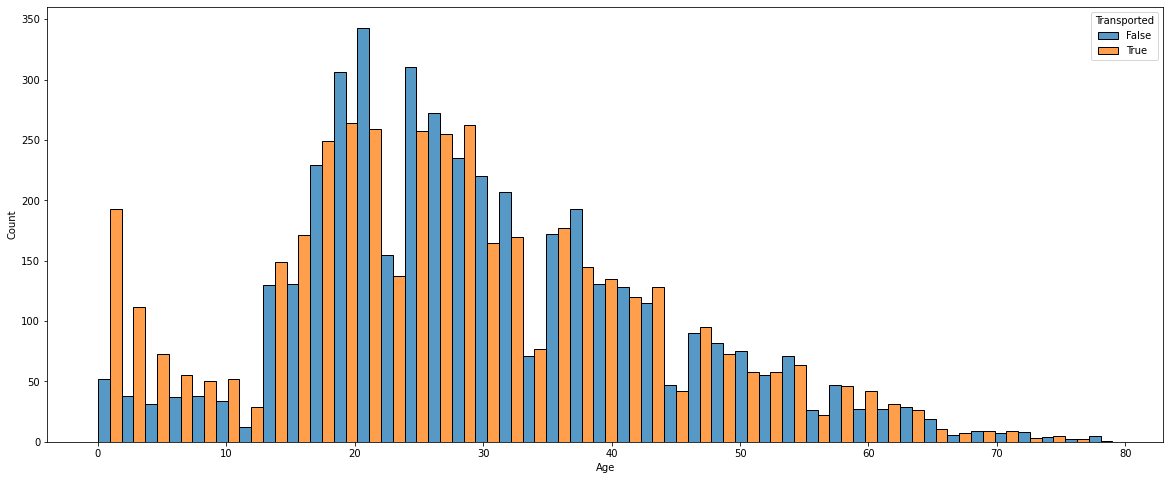

In [26]:
# Age

plt.figure(figsize=(20,8))
sns.histplot(
    data=org_data,
    x='Age',
    hue='Transported',
    multiple='dodge'
)
plt.show()

# 전처리에 평균 값으로 채웠기 때문에 분포에 약간의 차이가 있다
# 아이들은 그 수에 비해 이송된 비율이 높다
# 15세에서 40세 사이의 사람들이 가장 많이 이송되지 않았다
# 분포는 비슷한 패턴을 따르지만 연령대가 높은 사람의 수는 감소한다

In [27]:
# VIP

fig = px.pie(
    names=org_data.VIP.unique()[:-1],
    values=data.VIP.value_counts(),
    width=500,
    hole=0.4,
)
fig.update_layout({'title':{'text':'VIP','x':0.48}})
fig.show()

# 승객 대부분이 VIP 서비스를 받지 않는다

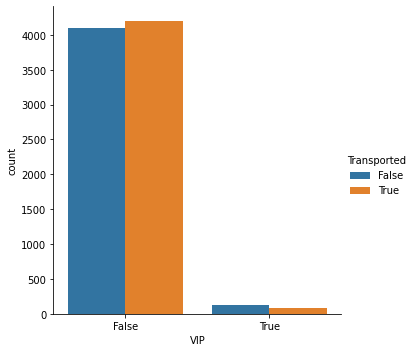

In [28]:
# VIP (2)

sns.catplot(
    data=org_data,
    x='VIP',
    kind='count',
    aspect=1,
    height=5,
    hue="Transported"
)
plt.show()

# 일반 승객이 VIP 회원보다 더 많이 이송되었다

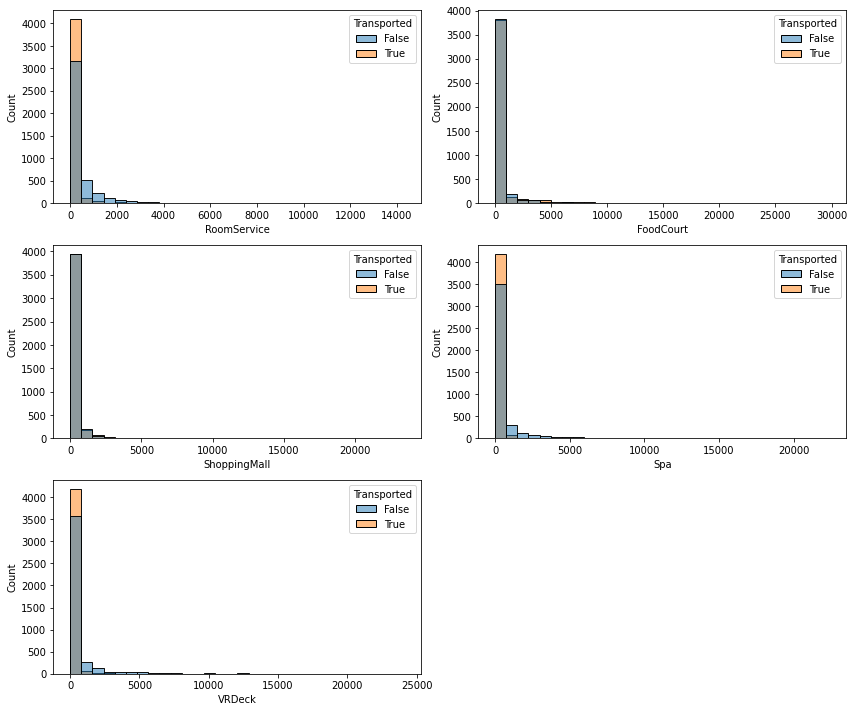

In [47]:
# 'RoomService','FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'의 대다수의 값은 0이다
# 승객들은 대부분 서비스를 이용하지 않았다

exp_feats=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

fig=plt.figure(figsize=(12,10))

for i,name in enumerate(exp_feats):
    ax = fig.add_subplot(3,2,i+1)
    sns.histplot(data=org_data, x=name, axes=ax, bins=30, kde=False, hue='Transported')

plt.tight_layout()  
plt.show()

In [30]:
# Transported

fig = px.pie(
    names=org_data.Transported.unique(),
    values=org_data.Transported.value_counts(),
    hole=0.4,
    width=500
)
fig.update_layout({'title':{'text':'Transported','x':0.5}})
fig.show()

# 데이터가 두 클래스에 균등하게 분포되어 있다
# 어떤 클래스에 편향될 수 없다

# 4. 모델링

In [31]:
# 학습 데이터 안에서 데이터 분리

Y_full = data.pop('Transported')
X_full = data

In [32]:
# 표준화

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)

In [33]:
# 학습 데이터 내에서 검증 데이터셋 분리

X_train, X_val, y_train, y_val = train_test_split(X_scaled, Y_full, test_size=0.2)

In [34]:
# LightGBM

model_lgb = lgb.LGBMClassifier()

In [35]:
# 하이퍼파라미터 튜닝 - RandomizedSearchCV

params_lgb = {
    "n_estimators": [100, 500, 1000], # tree numbers
    "learning_rate": [0.01, 0.05, 0.1, 0.3], # learning rate
    "lambda_l1": [0, 10, 20, 30, 50], # L1
    "lambda_l2": [0, 10, 20, 30, 50], # L2
    "max_depth": [5, 10, 15, 20], # max depth of trees
    "subsample": [0.6, 0.8, 1] # subsmaple rate
}

In [37]:
# 랜덤서치 적용

model_lgb_rs = RandomizedSearchCV(model_lgb, param_distributions=params_lgb, n_iter=30, scoring="roc_auc", n_jobs=-1)

# 모델 학습
model_lgb_rs.fit(X_scaled, Y_full)

RandomizedSearchCV(estimator=LGBMClassifier(), n_iter=30, n_jobs=-1,
                   param_distributions={'lambda_l1': [0, 10, 20, 30, 50],
                                        'lambda_l2': [0, 10, 20, 30, 50],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.3],
                                        'max_depth': [5, 10, 15, 20],
                                        'n_estimators': [100, 500, 1000],
                                        'subsample': [0.6, 0.8, 1]},
                   scoring='roc_auc')

In [38]:
# 최적의 파라미터 확인

model_lgb_rs.best_params_

{'subsample': 0.6,
 'n_estimators': 100,
 'max_depth': 10,
 'learning_rate': 0.05,
 'lambda_l2': 10,
 'lambda_l1': 0}

In [39]:
# 학습한 모델의 테스트 데이터셋에 대한 예측 결과 반환

pred = model_lgb_rs.predict(X_val)

In [40]:
# 성능 평가

accuracy_score(y_val, pred)

0.8200115008625647

In [41]:
model_lgb_rs.score(X_val, y_val)

0.9124442256696889

# 5. 테스트 데이터 예측 및 제출

In [42]:
# test data 적용

pred_test = model_lgb_rs.predict(test)

In [43]:
# 예측값 submission에 입력

submission['Transported'] = pred_test

# submission 입력 결과 확인

submission

,PassengerId,Transported
0,0013_01,1.0
1,0018_01,0.0
2,0019_01,1.0
3,0021_01,0.0
4,0023_01,0.0
...,...,...
4272,9266_02,1.0
4273,9269_01,0.0
4274,9271_01,1.0
4275,9273_01,0.0


In [48]:
# csv 파일 만든 뒤 결과물 저장

submission.to_csv('/content/drive/MyDrive/Colab Notebooks/인공지능/타이타닉_승객 이송/submission.csv', index = False)